In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import matplotlib.pyplot as plt
import os
config = dotenv_values(find_dotenv())
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [6]:
# import my merged data
data = pd.read_pickle(path_cleandata + 'BEA6_naics6_merged.pkl')

In [7]:
# filter for the year 2017 
data2017 = data[data['date'].dt.year == 2017]

In [8]:
# personal consumption expenditures
data2017 = data2017[data2017['product_O'].str.contains('Personal consumption expenditures')][['product_I', 'date', 'IO_value', 'expenditures_I']]

In [9]:
# sum by product for 2017 expenditures data
byproduct = data2017.groupby(['product_I']).agg({
    'IO_value': 'mean',
    'expenditures_I': 'mean'}, min_count=1).reset_index()

print(byproduct.set_index('product_I')[['IO_value', 'expenditures_I']].sum(axis=0))

IO_value          12529528.00
expenditures_I    11201031.75
dtype: float64


## taking a look at how well the merge worked

In [10]:
# create distance variable
byproduct['distance'] = np.abs(byproduct['IO_value'] - byproduct['expenditures_I'])

# kinda "outliers" that have a very different value
outlier_threshold = 75000

# Filter only the points that are outliers
outliers = byproduct[byproduct['distance'] > outlier_threshold]

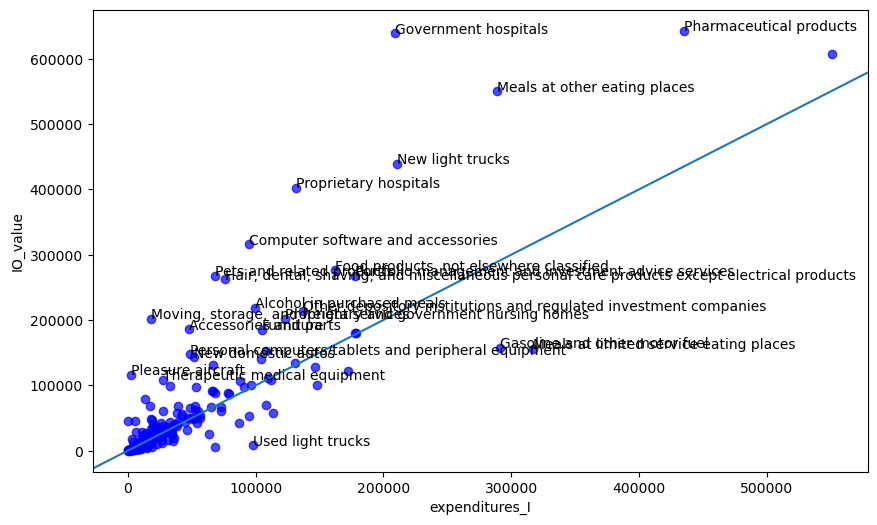

In [11]:
# do the scatter plot with expenditures on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(byproduct['expenditures_I'], byproduct['IO_value'], c='blue', alpha=0.7)

plt.xlabel('expenditures_I')
plt.ylabel('IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in list(set(outliers['product_I'])):
        plt.annotate(byproduct['product_I'][idx], (byproduct['expenditures_I'][idx], byproduct['IO_value'][idx]))

plt.savefig(path_figures + 'merge_check\\expenditures.pdf', bbox_inches='tight')

In [12]:
# this is the list of "outlier" products: issues mostly come from housing and healthcare type stuff
# noting the 2017 expenditures for tenant-occupied stationary houses is 0: having trouble getting min_count to work (actually all NaNs)
# within the merge, foreign travel in the United States gets matched with the rest-of-world adjustment in the IO table, which i should probably get rid of
outliers

,product_I,IO_value,expenditures_I,distance
0,Accessories and parts,185602.605010,48016.25,137586.355010
2,Alcohol in purchased meals,218570.558892,99191.00,119379.558892
26,Computer software and accessories,316173.597551,94691.75,221481.847551
46,"Food products, not elsewhere classified",276023.297640,161953.75,114069.547640
50,Furniture,184643.792276,104784.25,79859.542276
53,Gasoline and other motor fuel,157253.788391,291553.50,134299.711609
55,Government hospitals,639298.780008,209110.00,430188.780008
57,"Hair, dental, shaving, and miscellaneous perso...",262256.397580,76118.00,186138.397580
85,Meals at limited service eating places,155472.202229,317183.00,161710.797771
86,Meals at other eating places,550358.247589,289212.00,261146.247589


In [13]:
# go into concordance, which shows some of the issues

concordance = pd.read_pickle(path_cleandata + 'concordance//concordance6_naics6_addproportions.pkl')
outlierproducts = list(outliers['product_I'])

outliermerges = concordance[concordance['product'].isin(outlierproducts)]
outliermerges

,product,NAICS_desc,IO_proportions
0,New domestic autos,Automobile manufacturing,0.739080
1,New domestic autos,Motor vehicle body manufacturing,1.000000
3,New light trucks,Light truck and utility vehicle manufacturing,1.000000
6,Used light trucks,Scrap,0.209903
7,Used light trucks,Used and secondhand goods,0.065555
...,...,...,...
616,"Moving, storage, and freight services",Air transportation,0.058310
617,"Moving, storage, and freight services",Water transportation,0.235011
618,"Moving, storage, and freight services",Truck transportation,1.000000
619,"Moving, storage, and freight services",Warehousing and storage,1.000000


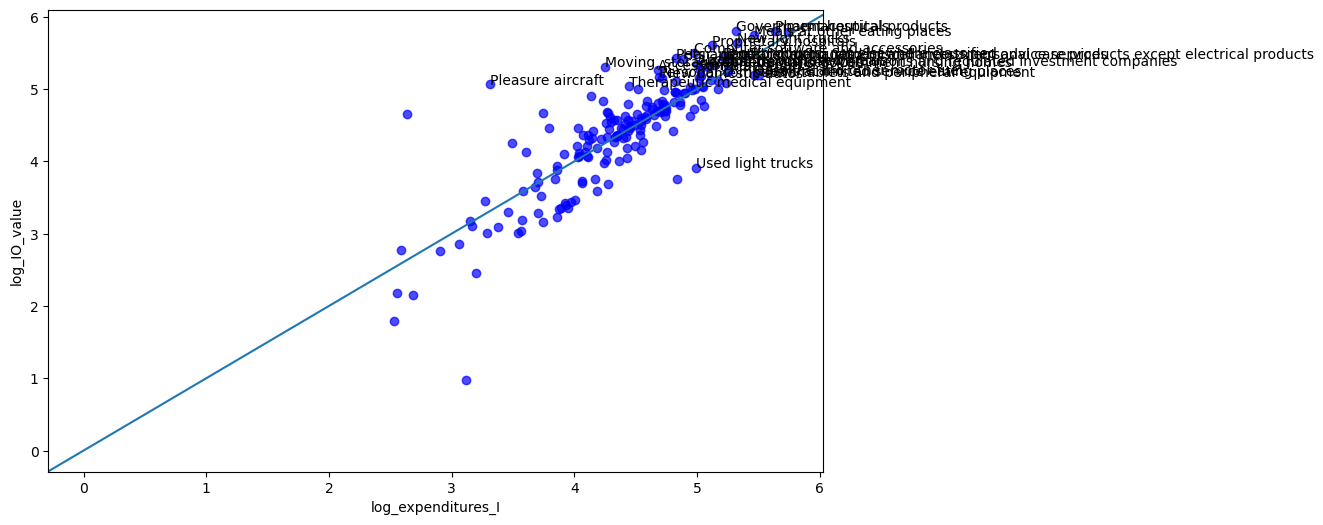

In [14]:
# get logs of everything and do an equivalent scatter plot with those

# do the scatter plot with expenditures on the x axis 
# do a base 10 log
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(byproduct['expenditures_I']), np.log10(byproduct['IO_value']), c='blue', alpha=0.7)

plt.xlabel('log_expenditures_I')
plt.ylabel('log_IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)


for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in list(set(outliers['product_I'])):
        plt.annotate(byproduct['product_I'][idx], (np.log10(byproduct['expenditures_I'])[idx], np.log10(byproduct['IO_value'])[idx]))

plt.savefig(path_figures + 'merge_check\\log_expenditures.pdf', bbox_inches='tight')
